In [1]:
# library imports 
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

# import neural net
# from models import Net
# net = Net()
# print(net)

In [2]:
net = torch.hub.load('pytorch/vision:v0.6.0', 'vgg11', pretrained=True)
net.eval()

Using cache found in C:\Users\Omer/.cache\torch\hub\pytorch_vision_v0.6.0


Image name  data/train/melanoma\ISIC_0000002.jpg
Shape of data  (2000, 2)


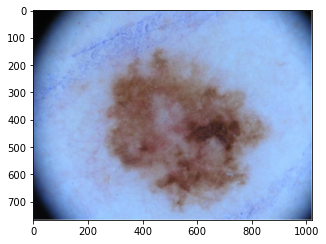

Classified as melanoma
Length of dataset:  2000
0 (674, 962, 3)
1 (4401, 6601, 3)
2 (2592, 3872, 3)
0 torch.Size([3, 224, 224]) 0
1 torch.Size([3, 224, 224]) 0
2 torch.Size([3, 224, 224]) 0
3 torch.Size([3, 224, 224]) 0
4 torch.Size([3, 224, 224]) 0
0 torch.Size([3, 224, 224])
1 torch.Size([3, 224, 224])
2 torch.Size([3, 224, 224])
3 torch.Size([3, 224, 224])


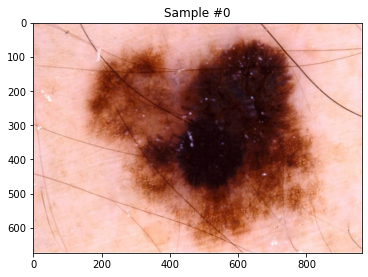

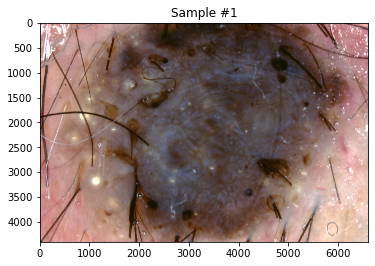

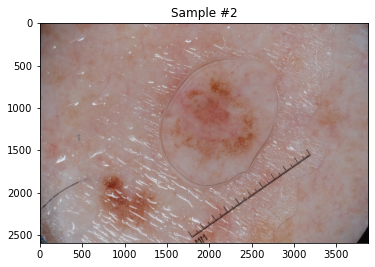

In [3]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

from data_load import SkinCancerDataset
from data_load import Rescale, RandomCrop, Normalize, ToTensor

data_transform = transforms.Compose([Rescale((300, 300)),
                                    RandomCrop(224),
                                    Normalize(),
                                    ToTensor()])

transformed_dataset = SkinCancerDataset(csv_file='data/train/ground_truth.csv', root_dir='data/train/', transform=data_transform)

for i in range(4):
    sample = transformed_dataset[i]
    print(i, sample['image'].size())

In [4]:
# Batching and loading training / test data

batch_size = 10
train_loader = DataLoader(transformed_dataset,
                         batch_size = batch_size,
                         shuffle=True,
                         num_workers=4)


In [5]:
# Loading test data
test_dataset = SkinCancerDataset(csv_file='data/test/ground_truth.csv', root_dir='data/test', transform=data_transform)

test_loader = DataLoader(test_dataset,
                        batch_size = batch_size,
                        shuffle=True,
                        num_workers=4)

In [6]:
# test the model on a batch of test images

def net_sample_output():
    
    # iterate through the test dataset
    for i, sample in enumerate(test_loader):
        
        # get sample data: images and ground truth keypoints
        images = sample['image']
        img_class = sample['class']

        # convert images to FloatTensors
        images = images.type(torch.FloatTensor)

        # forward pass to get net output
        output = net(images)
        
        # break after first image is tested
        if i == 0:
            return images, output, img_class

In [7]:
# Set loss and optimization
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [8]:
def train_net(n_epochs):

    # prepare the net for training
    net.train()

    for epoch in range(n_epochs):  # loop over the dataset multiple times
        
        running_loss = 0.0

        # train on batches of data, assumes you already have train_loader
        for batch_i, data in enumerate(train_loader):
            # get the input images and their corresponding labels
            images = data['image']
            img_class = data['class']

            # convert variables to floats for regression loss
#             img_class = img_class.type(torch.FloatTensor)
            images = images.type(torch.FloatTensor)

            # zero the parameter (weight) gradients
            optimizer.zero_grad()

            # forward pass to get outputs
            output_pts = net(images)

            # calculate the loss between predicted and target keypoints
            loss = criterion(output_pts, img_class)

#             # zero the parameter (weight) gradients
#             optimizer.zero_grad()
            
            # backward pass to calculate the weight gradients
            loss.backward()

            # update the weights
            optimizer.step()

            # print loss statistics
            running_loss += loss.item()
            if batch_i % 10 == 9:    # print every 10 batches
                print('Epoch: {}, Batch: {}, Avg. Loss: {}'.format(epoch + 1, batch_i+1, running_loss/10))
                running_loss = 0.0

    print('Finished Training')


In [ ]:
# train network
n_epochs = 2

train_net(n_epochs)

Epoch: 1, Batch: 10, Avg. Loss: 3.5404688239097597
Epoch: 1, Batch: 20, Avg. Loss: 1.1114716589450837
Epoch: 1, Batch: 30, Avg. Loss: 1.2475665509700775
Epoch: 1, Batch: 40, Avg. Loss: 1.2623996883630753
Epoch: 1, Batch: 50, Avg. Loss: 1.0870907068252564
Epoch: 1, Batch: 60, Avg. Loss: 1.0457868576049805
Epoch: 1, Batch: 70, Avg. Loss: 1.0657023310661315
Epoch: 1, Batch: 80, Avg. Loss: 0.8459778189659118
Epoch: 1, Batch: 90, Avg. Loss: 0.9049545466899872
Epoch: 1, Batch: 100, Avg. Loss: 0.9618139743804932
Epoch: 1, Batch: 110, Avg. Loss: 1.0908047020435334
Epoch: 1, Batch: 120, Avg. Loss: 0.8832706540822983
Epoch: 1, Batch: 130, Avg. Loss: 0.8858398199081421
Epoch: 1, Batch: 140, Avg. Loss: 0.8266541063785553
Epoch: 1, Batch: 150, Avg. Loss: 1.0258833944797516
Epoch: 1, Batch: 160, Avg. Loss: 0.800113421678543
Epoch: 1, Batch: 170, Avg. Loss: 0.9221570521593094
Epoch: 1, Batch: 180, Avg. Loss: 1.0485481202602387


In [ ]:
test_images, test_outputs, gt_class = net_sample_output()

print(test_images.data.size())
print(test_outputs.data.size())

In [ ]:
# visualize output from trained model
plt.figure(figsize=(20,10))
# _,predicted_class = torch.max(test_outputs.data, 1)
predicted_class = test_outputs.data
predicted_class = predicted_class.numpy()
for i in range(batch_size):
    ax = plt.subplot(2, batch_size/2, i+1)
    
    image = test_images[i]
    image = image.numpy()
    image = np.transpose(image, (1, 2, 0))
    
    ax.imshow(np.squeeze(image), cmap='gray')
#     predicted = np.argmax(predicted_class[i], axis=0)
    predicted = max(predicted_class[i])
    
    true_class = gt_class[i]
    print("predicted:", predicted_class[i], predicted)
    print("actual:", true_class.numpy())
    plt.show()
#plt.show()
    

In [ ]:
# # obtain one batch of test images
# dataiter = iter(test_loader)
# images, labels = dataiter.next()
# # get predictions
# preds = np.squeeze(net(images).data.max(1, keepdim=True)[1].numpy())
# images = images.numpy()

# # plot the images in the batch, along with predicted and true labels
# fig = plt.figure(figsize=(25, 4))
# for idx in np.arange(batch_size):
#     ax = fig.add_subplot(2, batch_size/2, idx+1, xticks=[], yticks=[])
#     ax.imshow(np.squeeze(images[idx]), cmap='gray')
#     ax.set_title("{} ({})".format(classes[preds[idx]], classes[labels[idx]]),
#                  color=("green" if preds[idx]==labels[idx] else "red"))

In [ ]:
model_dir = 'saved_models/'
model_name = 'skincancer_model_1.pt'

# after training, save your model parameters in the dir 'saved_models'
torch.save(net.state_dict(), model_dir+model_name)